We use 10X Visium human invasive ductal carcinoma (IDC) and mouse brain sagittal posterior (MBSP) as examples to show how to use DIST python package to perform transfer-learning Spatial Transcriptomics enhancement. The count matrix of two samples can be found in folder data or be downloaded from [IDC](https://www.10xgenomics.com/resources/datasets/invasive-ductal-carcinoma-stained-with-fluorescent-cd-3-antibody-1-standard-1-2-0) and [MBSP](https://www.10xgenomics.com/resources/datasets/mouse-brain-serial-section-1-sagittal-posterior-1-standard-1-1-0).

In [5]:
import anndata as ad
import scanpy as sc
from DIST import *
from scipy.sparse import csr_matrix

## Data preparation

Prepare for training set.

In [6]:
# Load 10X visium data
train_adata=sc.read_visium("data/Mouse_Brain_Sagittal_Posterior") 
train_adata.var_names_make_unique()
# QC
sc.pp.calculate_qc_metrics(train_adata, inplace=True)
sc.pp.filter_cells(train_adata, min_genes=200)
sc.pp.filter_genes(train_adata, min_cells=10)
# In the training process, we choose genes that expressed on over ten percent of total spots. The percentage can be adjusted.
train_adata=train_adata[:,train_adata.var["n_cells_by_counts"]>len(train_adata.obs.index)*0.1]
# Get count matrix and coordinate matrix, they are inputs of DIST algorithm.
train_counts=np.array(train_adata.X.todense())
train_coords=train_adata.obs[['array_row','array_col']]
train_adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/data1/zyp/miniconda3/envs/testdist/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)


View of AnnData object with n_obs × n_vars = 3339 × 10643
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

Prepare for test set.

In [7]:
# Load 10X visium data
test_adata=sc.read_visium("data/Human_Invasive_Ductal_Carcinoma") 
test_adata.var_names_make_unique()
# Define integral_coords.
# It describes row and column coordinates of some original spots that are expected to preserve.
# Usually, intergral_coords contains the initial spots of test data without quality control.
integral_coords=test_adata.obs[['array_row','array_col']]
# QC
sc.pp.calculate_qc_metrics(test_adata, inplace=True)
sc.pp.filter_cells(test_adata, min_genes=200)
sc.pp.filter_genes(test_adata, min_cells=10)
# Get count matrix and coordinate matrix, they are inputs of DIST algorithm.
test_counts=np.array(test_adata.X.todense())
test_coords=test_adata.obs[['array_row','array_col']]
test_adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 4723 × 17849
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

## DIST imputation

Create training and test dataset from expression and cooridate matrix.  
Get information about imputed coordinates for transforming outputs of DIST network into expression and coordinates matrices.

In [8]:
train_set=get10Xtrainset(train_counts, train_coords)
test_set=get10Xtestset(test_counts, test_coords)
position_info=get_10X_position_info(integral_coords)

Creating training set costs:  71.02 s
Creating testing set costs:  116.58 s


If you want to denoise imputed results, you can introduce synthetic noises to inputs of training data as follows. If not, ignore it.

In [4]:
#efficiency=0.6
#train_lr1=np.random.poisson(efficiency*train_lr)
#train_set=[train_lr1,train_hr,in_tissue_matrix]

Run DIST.

In [9]:
imputed_img = DIST(train_set,test_set, epoch=200, batch_size=512, gpu='2')
imputed_counts, imputed_coords = img2expr(imputed_img, test_adata.var_names, integral_coords, position_info)

Training: 100%[##################################################->]434.38s

Testing: 100%[##################################################->]38.72s



Here, we have gotten imputed expression matrix and its spots coordinates matrix. You can create anndata.AnnData object for imputed expression, if necessary.

In [10]:
imputed_adata=ad.AnnData(X=imputed_counts,obs=imputed_coords)
imputed_adata.X=csr_matrix(imputed_adata.X)
imputed_adata

AnnData object with n_obs × n_vars = 18617 × 17849
    obs: 'array_row', 'array_col'

--------------------------------------------------
Next, we visualize some genes to show the effect of DIST.
## Visualization

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_genes(adata, show_genes, n=4, size=(20,5),point_size=30, titles=None,cmap=None):
    if titles==None:
        titles=show_genes
    genes_index=[list(adata.var_names).index(gene) for gene in show_genes]
    m=len(show_genes)//n+1
    plt.figure(figsize=size)
    flag=0
    for j in range(m):
        show_genes0=show_genes[j*n:min(len(show_genes),(j+1)*n)]
        
        for i in range(n):
            if not i<len(show_genes0):
                break
            plt.subplot(m,n,flag+1)
        
            plt.scatter(adata.obs['array_col'],adata.obs['array_row'],c=np.array(adata.X.todense())[:,genes_index[flag]],
                        marker='.',s=point_size, vmin=0,cmap=cmap)
            plt.title(titles[flag])
            plt.xticks([])
            plt.yticks([])
            plt.gca().invert_yaxis()
            plt.gca().invert_xaxis()
            plt.axis('off')
            flag+=1

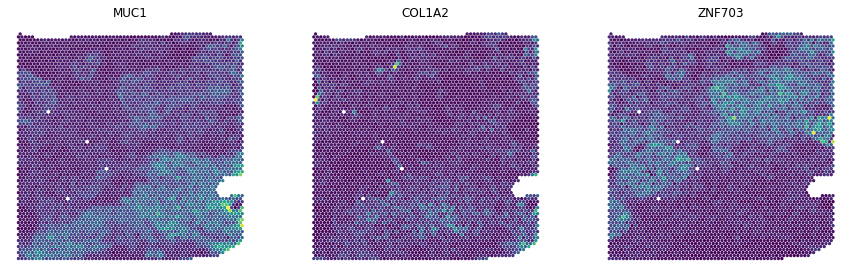

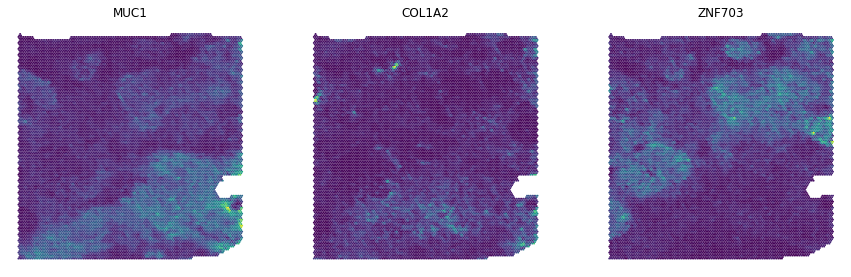

In [18]:
show_genes=['MUC1','COL1A2','ZNF703']
plot_genes(test_adata, show_genes, n=3, size=(15,10),point_size=20)
plot_genes(imputed_adata, show_genes, n=3, size=(15,10),point_size=3)